# Cleaning MUR Climatology Data

**Goal**
<br/>
To clean the MUR Climatology dataset created by Jorge Vazquez so that it can be in the proper format for use in creating a SST Anomaly dataset in the Jupyter notebook "MURSSTAnomaly.ipynb".

**Run Location**
<br/>
This notebook was run locally, but can also run on an Amazon Web Services (AWS) EC2 instance given enough memory for dataset operations.

**Dataset**
<br/>
MUR 1-km L4 SST https://registry.opendata.aws/mur/

### Import Modules

In [1]:
import s3fs
import numpy as np
import xarray as xr
import fsspec
import zarr
from dask.distributed import Client

### Dataset URL
<br/>
We use this URL to reference the MUR 1-km L4 dataset on the AWS Open Registry.

In [2]:
URL = 's3://mur-sst/zarr'

### Period and Region of Interest

In [6]:
start_date = "2004-01-01"
end_date = "2004-12-31"

minlat = 18
maxlat = 25
minlon = -160
maxlon = -150

### Open Dataset
<br/>
Open the remote dataset from its S3 endpoint. The dataset is pre-consolidated, meaning the metadata is stored in a single, optimized resource. We can take advantage of this by declaring 'consolidated=True' which uses that resource to reduce the number of read operations when opening the data.

In [3]:
ds = xr.open_zarr(fsspec.get_mapper(URL, anon=True), consolidated=True)

In [4]:
ds

,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Slice Dataset to Create Subset
<br/>
We will slice this dataset along its latitude, longitude, and time dimensions in order to create the data subset we will use for passing dimensions to the updated climatology dataset.

In [7]:
variables=[
    'analysed_sst', 
    'mask'
]

mur_subset = ds[variables].sel(
    time=slice(start_date, end_date),
    lat=slice(minlat, maxlat), 
    lon=slice(minlon, maxlon),
).chunk({"time": 30, "lat": 100, "lon": 100})

In [8]:
mur_subset

,Array,Chunk
Bytes,1.03 GB,1.20 MB
Shape,"(366, 701, 1001)","(30, 100, 100)"
Count,70128 Tasks,1144 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,256.82 MB,300.00 kB
Shape,"(366, 701, 1001)","(30, 100, 100)"
Count,70128 Tasks,1144 Chunks
Type,int8,numpy.ndarray


### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [9]:
mur_subset_no_land = mur_subset['analysed_sst'].where(mur_subset.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [10]:
mur_subset_final = mur_subset_no_land - 273.15

In [11]:
mur_subset_final

,Array,Chunk
Bytes,1.03 GB,1.20 MB
Shape,"(366, 701, 1001)","(30, 100, 100)"
Count,143688 Tasks,1144 Chunks
Type,float32,numpy.ndarray


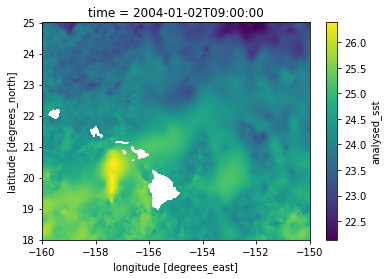

In [12]:
mur_subset_final.isel(time=1).plot()

### Load in MUR Climatology Data

In [13]:
mur_clim = xr.open_dataset("../data/murclim3d.nc")

In [14]:
mur_clim = mur_clim.rename({
    'x': 'lon',
    'y': 'lat', 
    'z': 'time'
})

In [15]:
mur_clim

<xarray.Dataset>
Dimensions:     (lat: 701, lon: 1001, time: 365)
Dimensions without coordinates: lat, lon, time
Data variables:
    sstclim     (time, lat, lon) float32 ...
    _FillValue  float32 ...
Attributes:
    start_date:  01/01
    end_date:    12/31

### Remove the __FillValue_ Variable

In [16]:
mur_clim_sst = mur_clim["sstclim"]

In [17]:
mur_clim_sst

<xarray.DataArray 'sstclim' (time: 365, lat: 701, lon: 1001)>
[256120865 values with dtype=float32]
Dimensions without coordinates: time, lat, lon

### Create Leap Day with Data from February 28th
<br/>
This climatology data only has observations from 365 days, so leap days have been ignored. When using this data to create the SST Anomaly dataset we will need 366 days of observations so that the shapes of the time dimensions line up. In order to do this, we are concatenating an extra day to the climatology data for February 29th from the data from February 28th.

In [18]:
extra_day = xr.DataArray(
    data=mur_clim_sst[58],
    dims=["lat", "lon"],
    attrs=dict(
        description="Hawaii Climatology from 2002-2015.",
        start_date="01/01",
        end_date="12/31",
        units="degC"
    )
)

In [19]:
extra_day = extra_day.expand_dims({"time" : 1})

In [20]:
extra_day

<xarray.DataArray 'sstclim' (time: 1, lat: 701, lon: 1001)>
array([[[24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   ,
         24.117004],
        [24.790985, 24.800995, 24.812988, ..., 24.104004, 24.109009,
         24.114014],
        [24.791992, 24.803986, 24.817993, ..., 24.101013, 24.105988,
         24.110992],
        ...,
        [22.442993, 22.446014, 22.451996, ..., 22.101013, 22.10199 ,
         22.102997],
        [22.446014, 22.447998, 22.450012, ..., 22.114014, 22.117004,
         22.118988],
        [22.450012, 22.450012, 22.450012, ..., 22.132996, 22.136993,
         22.139008]]], dtype=float32)
Dimensions without coordinates: time, lat, lon
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Concatenate Leap Day to the MUR Climatology
<br/>
This concatenation adds the extra day to the end of the climatology dataset.

In [21]:
mur_clim_ex = xr.concat([mur_clim_sst, extra_day], dim="time")

In [22]:
mur_clim_ex["time"]

<xarray.DataArray 'time' (time: 366)>
array([  0,   1,   2, ..., 363, 364, 365])
Dimensions without coordinates: time

In [23]:
mur_clim_ex[58]

<xarray.DataArray 'sstclim' (lat: 701, lon: 1001)>
array([[24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   ,
        24.117004],
       [24.790985, 24.800995, 24.812988, ..., 24.104004, 24.109009,
        24.114014],
       [24.791992, 24.803986, 24.817993, ..., 24.101013, 24.105988,
        24.110992],
       ...,
       [22.442993, 22.446014, 22.451996, ..., 22.101013, 22.10199 ,
        22.102997],
       [22.446014, 22.447998, 22.450012, ..., 22.114014, 22.117004,
        22.118988],
       [22.450012, 22.450012, 22.450012, ..., 22.132996, 22.136993,
        22.139008]], dtype=float32)
Dimensions without coordinates: lat, lon

In [24]:
mur_clim_ex[365]

<xarray.DataArray 'sstclim' (lat: 701, lon: 1001)>
array([[24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   ,
        24.117004],
       [24.790985, 24.800995, 24.812988, ..., 24.104004, 24.109009,
        24.114014],
       [24.791992, 24.803986, 24.817993, ..., 24.101013, 24.105988,
        24.110992],
       ...,
       [22.442993, 22.446014, 22.451996, ..., 22.101013, 22.10199 ,
        22.102997],
       [22.446014, 22.447998, 22.450012, ..., 22.114014, 22.117004,
        22.118988],
       [22.450012, 22.450012, 22.450012, ..., 22.132996, 22.136993,
        22.139008]], dtype=float32)
Dimensions without coordinates: lat, lon

### Sort the DataArray
<br/>
We do this in order to move the leap day data to where February 29th should be rather than it being the last day in the dataset.

In [25]:
order = np.arange(0, 366, 1)

In [26]:
order[59] = 365

In [27]:
order[365] = 59

In [28]:
order_dim = xr.DataArray(
    data=order,
    dims=["time"],
    attrs=dict(
        description="Hawaii Climatology from 2002-2015.",
        start_date="01/01",
        end_date="12/31",
        units="degC"
    )
)

In [29]:
order_dim

<xarray.DataArray (time: 366)>
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58, 365,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
       351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363,
       364,  59])
Dimensions without coordinates: time
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

In [30]:
mur_clim_ordered = mur_clim_ex.sortby(order_dim)

In [33]:
mur_clim_ordered

<xarray.DataArray 'sstclim' (time: 366, lat: 701, lon: 1001)>
array([[[25.445007, 25.446014, 25.450989, ..., 24.459991, 24.45401 ,
         24.450989],
        [25.45401 , 25.453003, 25.455994, ..., 24.447998, 24.441986,
         24.440002],
        [25.46701 , 25.46399 , 25.46399 , ..., 24.437012, 24.432007,
         24.432007],
        ...,
        [23.924011, 23.923004, 23.920013, ..., 22.971008, 22.963013,
         22.951996],
        [23.915009, 23.911987, 23.90799 , ..., 22.966003, 22.958008,
         22.947998],
        [23.903015, 23.898987, 23.894989, ..., 22.960999, 22.953003,
         22.945007]],

       [[25.449005, 25.458008, 25.467987, ..., 24.403992, 24.398987,
         24.393005],
        [25.447998, 25.454987, 25.464996, ..., 24.401001, 24.395996,
         24.390015],
        [25.450012, 25.455994, 25.463013, ..., 24.391998, 24.389008,
         24.384003],
...
        [23.865997, 23.865997, 23.86499 , ..., 23.026001, 23.015991,
         23.007996],
        [23.860992, 23.862   , 23.859985, ..., 23.02301 , 23.010986,
         23.001007],
        [23.859985, 23.860992, 23.858002, ..., 23.016998, 23.00299 ,
         22.98999 ]],

       [[24.730011, 24.735992, 24.740997, ..., 24.096008, 24.105011,
         24.112   ],
        [24.718994, 24.72699 , 24.735992, ..., 24.095001, 24.102997,
         24.108002],
        [24.714996, 24.722992, 24.731995, ..., 24.09201 , 24.096985,
         24.10199 ],
        ...,
        [22.358002, 22.363007, 22.365997, ..., 22.08899 , 22.09201 ,
         22.093994],
        [22.356995, 22.360992, 22.363007, ..., 22.09201 , 22.096008,
         22.096985],
        [22.355011, 22.359985, 22.360992, ..., 22.096985, 22.101013,
         22.10199 ]]], dtype=float32)
Dimensions without coordinates: time, lat, lon

In [34]:
mur_clim_ordered[59]

<xarray.DataArray 'sstclim' (lat: 701, lon: 1001)>
array([[24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   ,
        24.117004],
       [24.790985, 24.800995, 24.812988, ..., 24.104004, 24.109009,
        24.114014],
       [24.791992, 24.803986, 24.817993, ..., 24.101013, 24.105988,
        24.110992],
       ...,
       [22.442993, 22.446014, 22.451996, ..., 22.101013, 22.10199 ,
        22.102997],
       [22.446014, 22.447998, 22.450012, ..., 22.114014, 22.117004,
        22.118988],
       [22.450012, 22.450012, 22.450012, ..., 22.132996, 22.136993,
        22.139008]], dtype=float32)
Dimensions without coordinates: lat, lon

In [35]:
mur_clim_ordered[365]

<xarray.DataArray 'sstclim' (lat: 701, lon: 1001)>
array([[24.730011, 24.735992, 24.740997, ..., 24.096008, 24.105011,
        24.112   ],
       [24.718994, 24.72699 , 24.735992, ..., 24.095001, 24.102997,
        24.108002],
       [24.714996, 24.722992, 24.731995, ..., 24.09201 , 24.096985,
        24.10199 ],
       ...,
       [22.358002, 22.363007, 22.365997, ..., 22.08899 , 22.09201 ,
        22.093994],
       [22.356995, 22.360992, 22.363007, ..., 22.09201 , 22.096008,
        22.096985],
       [22.355011, 22.359985, 22.360992, ..., 22.096985, 22.101013,
        22.10199 ]], dtype=float32)
Dimensions without coordinates: lat, lon

### Create Organized MUR Climatology Dataset
<br/>
The original climatology data was organized strangely and xarray struggled to work with it, so a new dataset is created from that data with the dimensions of the subset MUR SST data from AWS.

In [36]:
lat = mur_subset_final['lat']
lon = mur_subset_final['lon']
time = mur_subset_final['time']

In [37]:
mur_clim_ds = xr.DataArray(
    data=mur_clim_ordered,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
        time=time
    ),
    attrs=dict(
        description="Hawaii Climatology from 2002-2015.",
        start_date="01/01",
        end_date="12/31",
        units="degC",
    )
)

### Add in NAN Values for Land to MUR Climatology
<br/>
Use the mask variable from the MUR SST subset like earlier to change the land observations to NaN values.

In [38]:
mur_clim_fixing = mur_clim_ds.where(mur_subset.mask == 1)

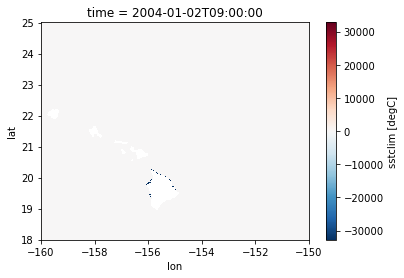

In [40]:
mur_clim_fixing.isel(time=1).plot()

### Fix Outlier Values
<br/>
When creating the previous plot it was realized that there is at least one outlier that is skewing the data and stopping it from being displayed properly. Due to the dark blue looking sections around the Hawaiin big island it is assumed that this/these value/values are negative. We fix this by filtering out values that are less than a certain threshold.

In [41]:
mur_clim_final = mur_clim_fixing.where(mur_clim_fixing > 0)

/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


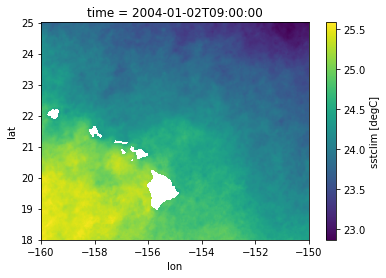

In [42]:
mur_clim_final.isel(time=1).plot()

In [43]:
mur_clim_final

,Array,Chunk
Bytes,1.03 GB,1.20 MB
Shape,"(366, 701, 1001)","(30, 100, 100)"
Count,76993 Tasks,1144 Chunks
Type,float32,numpy.ndarray


### Download File

In [40]:
mur_clim_final.to_netcdf("../data/MURClimatology.nc")

/Users/matthewthompson/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


### Test Opening the File

In [41]:
mur_clim_testing_data = xr.open_dataarray("../data/MURClimatology.nc")

In [42]:
mur_clim_testing_data

<xarray.DataArray 'sstclim' (time: 366, lat: 701, lon: 1001)>
[256822566 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 24.97 24.98 24.99 25.0
  * time     (time) datetime64[ns] 2004-01-01T09:00:00 ... 2004-12-31T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

In [43]:
mur_clim_testing_data[58][0]

<xarray.DataArray 'sstclim' (lon: 1001)>
array([24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   , 24.117004],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
    lat      float32 18.0
    time     datetime64[ns] 2004-02-28T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

In [44]:
mur_clim_testing_data[59][0]

<xarray.DataArray 'sstclim' (lon: 1001)>
array([24.791992, 24.799988, 24.809998, ..., 24.106995, 24.112   , 24.117004],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
    lat      float32 18.0
    time     datetime64[ns] 2004-02-29T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC